In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

num_duplicates = df.duplicated().sum()
print(f"Liczba duplikatów: {num_duplicates}")

### Data PreProcessing

In [93]:
#import dataset
df = pd.read_csv("D:/ml/xgboost-main/data/RT-IoT/RT_IOT2022")
df = df.drop(columns =["Unnamed: 0"])

#calassification: if normal communication: 1, attacks: 0
df['label'] = df['Attack_type'].isin(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']).astype(int)
df = df.drop_duplicates()

#drop from column="proto" when values="icmp" & tcp=1 udp=0
df = df[df['proto'] != 'icmp']
label = {'tcp':1,'udp':0}      
df = df.replace(label)

#change text from column="service" to int values by LabelEncoder()
le = LabelEncoder()
df['service_en'] = le.fit_transform(df['service'])
cols = df.columns.tolist()
index = cols.index('service')                                                   #find column='service'
cols.insert(index + 1, cols.pop(cols.index('service_en')))                      #paste column='service_encoded' after column='service'
df = df[cols]
mapping = dict(zip(le.classes_, le.transform(le.classes_)))                     #mapping text = value
print("\nMapped values for 'service_en':")
for name, encoded_value in mapping.items():
    print(f"'{name}' -> {encoded_value}")
df = df.drop(columns=["service"])                                               #drop column="service"

#change text from column="Attack_type" to int values by LabelEncoder()
df['Attack_type_en'] = le.fit_transform(df['Attack_type'])
cols = df.columns.tolist()
index = cols.index('Attack_type')                                               #find column='Attack_type'
cols.insert(index + 1, cols.pop(cols.index('Attack_type_en')))                  #paste column='Attack_type_en' after column='Attack_type'
df = df[cols]
mapping = dict(zip(le.classes_, le.transform(le.classes_)))                     #mapping text = value
print("\nMapped values for 'Attack_type_en':")
for name, encoded_value in mapping.items():
    print(f"'{name}' -> {encoded_value}")
df = df.drop(columns=["Attack_type"])                                           #drop column="Attack_tyope"
df.dtypes
df.head()

#add new column = "source" with value = "oryginal" and save
path = "D:\\ml\\xgboost-main\\data\\RT-IoT\\oryginal_dataset.csv"
df['source'] = 'original'
df.to_csv(path)


Mapped values for 'service_en':
'-' -> 0
'dhcp' -> 1
'dns' -> 2
'http' -> 3
'irc' -> 4
'mqtt' -> 5
'ntp' -> 6
'radius' -> 7
'ssh' -> 8
'ssl' -> 9

Mapped values for 'Attack_type_en':
'ARP_poisioning' -> 0
'DDOS_Slowloris' -> 1
'DOS_SYN_Hping' -> 2
'MQTT_Publish' -> 3
'Metasploit_Brute_Force_SSH' -> 4
'NMAP_FIN_SCAN' -> 5
'NMAP_OS_DETECTION' -> 6
'NMAP_TCP_scan' -> 7
'NMAP_UDP_SCAN' -> 8
'NMAP_XMAS_TREE_SCAN' -> 9
'Thing_Speak' -> 10
'Wipro_bulb' -> 11


In [ ]:
#prepare & generate train & test samples
df2 = df.drop(columns="source")
y = df2["label"]
X = df2.drop(columns=["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

#concat X_train & y_train -> used to save files
df_original = pd.concat([X_train, y_train], axis=1)          
df_original['source'] = 'oryginal'                              #new column = "source"

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\testframe\\iot\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\testframe\\iot\\X_test.csv")

""" 
df_data = df.copy()
dell = pd.concat([X_test, y_test], axis=1)      #polaczenie macierzy X_test oraz y_test
#print(dell.shape)           #271-55=216
target_num = dell['target'].value_counts()
print(f'Klasyfikator: {target_num}')
df_cleaned = df_data.merge(dell, how='left', indicator=True)        # Dodaje kolumnę '_merge' dla identyfikacji
df_cleaned = df_cleaned[df_cleaned['_merge'] == 'left_only'].drop('_merge', axis=1) """

(94310, 84)
(23578, 84)


" \ndf_data = df.copy()\ndell = pd.concat([X_test, y_test], axis=1)      #polaczenie macierzy X_test oraz y_test\n#print(dell.shape)           #271-55=216\ntarget_num = dell['target'].value_counts()\nprint(f'Klasyfikator: {target_num}')\ndf_cleaned = df_data.merge(dell, how='left', indicator=True)        # Dodaje kolumnę '_merge' dla identyfikacji\ndf_cleaned = df_cleaned[df_cleaned['_merge'] == 'left_only'].drop('_merge', axis=1) "

### OverSampling - SMOTE

Before Counter({0: 84746, 1: 9564})
After Counter({0: 84746, 1: 84746})


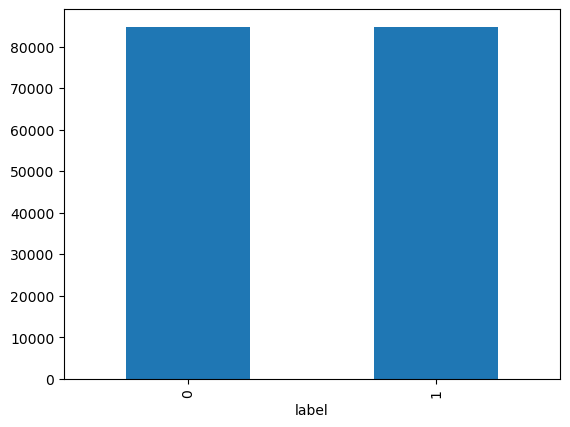

In [105]:
file_path1 = "D:\\ml\\xgboost-main\\data\\RT-IoT\\smote_data.csv"           #file_path to smote_data.csv
#generate new data by SMOTE
con = Counter(y_train)
print("Before", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("After", con1)
pd.Series(y_train_sm).value_counts().plot.bar()

#concat smote train X & y && save data
df_train = pd.concat([X_train_sm, y_train_sm], axis=1)          #concat smote train X & y
df_train['source'] = np.nan                                     #new column = "NaN"
df_train = df_train.combine_first(df_original)                  #combine data
df_train['source'] = df_train['source'].fillna('smote') 
generated_data = df_train[df_train['source'] == "smote"]
if not os.path.exists(file_path1):                              #save if exists
    generated_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}') 

### OverSampling - BorderLineSMOTE

Before Counter({0: 84746, 1: 9564})
After Counter({0: 84746, 1: 84746})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\RT-IoT\boarderlinesmote_data.csv


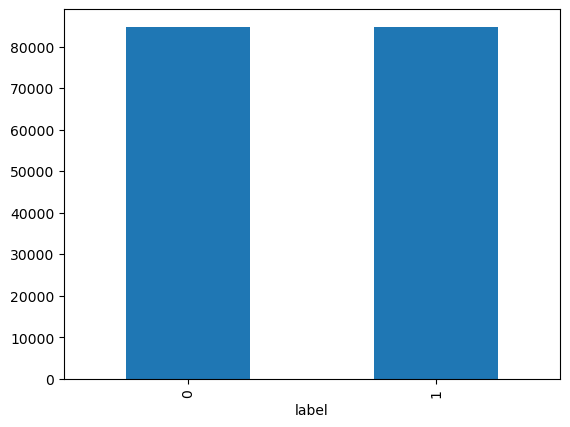

In [104]:
file_path2 = "D:\\ml\\xgboost-main\\data\\RT-IoT\\boarderlinesmote_data.csv"           #file_path to smote_data.csv
#generate new data by SMOTE
con = Counter(y_train)
print("Before", con)
borderlineSMOTE = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = borderlineSMOTE.fit_resample(X_train, y_train)
con1 = Counter(y_train_bsm)
print("After", con1)
pd.Series(y_train_bsm).value_counts().plot.bar()

#concat borderlinesmote train X & y && save data
df_train = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #concat smote train X & y
df_train['source'] = np.nan                                     #new column = "NaN"
df_train = df_train.combine_first(df_original)                  #combine data
df_train['source'] = df_train['source'].fillna('borderlinesmote') 
generated_data = df_train[df_train['source'] == "borderlinesmote"]
if not os.path.exists(file_path2):                              #save if exists
    generated_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}') 

### OverSampling - GAN

In [109]:
file_path3 = "D:\\ml\\xgboost-main\\data\\RT-IoT\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
con = Counter(y_train)
print("Before", con)
ctgan = CTGAN(epochs=2)
columns_list = df_original.columns
target_num = df_original['label'].value_counts()

chunk = 25000

if target_num[0] > target_num[1]:
    data_y1 = df_original[df_original['label']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['label'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
else:
    data_y0 = df_original[df_original['label']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['label'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)


y_bal = balanced_data["label"]
X_bal = balanced_data.drop(columns=["label"])
X_train_gan, _, y_train_gan, _ = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal)

# concat gan train X & y && save data
df_train = pd.concat([X_train_gan, y_train_gan], axis=1)          #concat smote train X & y
df_train['source'] = np.nan                                     #new column = "NaN"
df_train = df_train.combine_first(df_original)                  #combine data
df_train['source'] = df_train['source'].fillna('gan') 
generated_data = df_train[df_train['source'] == "gan"]
if not os.path.exists(file_path2):                              #save if exists
    generated_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}') 


Before Counter({0: 84746, 1: 9564})


MemoryError: Unable to allocate 15.6 GiB for an array with shape (9564, 218671) and data type float64

In [ ]:
models = {
    
    "LR": LogisticRegression(),             # logistic regression dla niezbalansowanych 
    "LR_SMOTE": LogisticRegression(),       # logistic regression dla zbalansowanych SMOTE
    "LR_BrdSMOTE": LogisticRegression(),    # logistic regression dla zbalansowanych BoarderrLineSMOTE
    "LR_GAN": LogisticRegression(),         # logistic regression dla zbalansowanych GAN
    
    "DT": DecisionTreeClassifier(),             # decision tree dla niezbalansowanych
    "DT_SMOTE": DecisionTreeClassifier(),       # decision tree dla zbalansowanych SMOTE
    "DT_BrdSMOTE": DecisionTreeClassifier(),     # decision tree dla zbalansowanych BoarderrLineSMOTE
    "DT_GAN": DecisionTreeClassifier(),          # decision tree dla zbalansowanych GAN
    
    "RF": RandomForestClassifier(),             # random forest dla niezbalansowanych
    "RF_SMOTE": RandomForestClassifier(),       # random forest dla zbalansowanych SMOTE
    "RF_BrdSMOTE": RandomForestClassifier(),    # random forest dla zbalansowanych BoarderrLineSMOTE
    "RF_GAN": RandomForestClassifier(),        # random forest dla zbalansowanych GAN
    
    "XGB": XGBClassifier(),           # xgboost dla niezbalansowanych
    "XGB_SMOTE": XGBClassifier(),     # xgboost dla zbalansowanych SMOTE
    "XGB_BrdSMOTE": XGBClassifier(),    # xgboost dla zbalansowanych BoarderrLineSMOTE
    "XGB_GAN": XGBClassifier(),       # xgboost dla zbalansowanych GAN
    
    "XGB_RF": XGBRFClassifier(),            # xgboost rf dla niezbalansowanych
    "XGB_RF_SMOTE": XGBRFClassifier(),         # xgboost rf dla zbalansowanych SMOTE
    "XGB_RF_BrdSMOTE": XGBRFClassifier(),   # xgboost rf dla zbalansowanych BoarderrLineSMOTE
    "XGB_RF_GAN": XGBRFClassifier()          # xgboost rf dla zbalansowanych GAN
}

fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}


### GridSearch

In [ ]:

# PARAMS to Search
params_LR = {                               # dla LR
    #'class_weight':['balanced', 'none'],   # wagi dla poszczegolnych klas
    'max_iter':[100,500,1000]  ,
    'random_state':[0,10,20,30,40]        # ustalona losowość dla powtarzalności
                # ilosc iteracji
}

params_DT = {                               # dla DT
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
    'min_samples_leaf':[1,2]                # minimalna ilosc probek lisci
}

params_RF = {
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
}

params_XGB = {                              # dla XGBoost
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'subsample':[0.5,0.6,0.7,0.8,0.9,1]
}

params_XGB_RF = {                           # dla XGBoost RF
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'random_state':[0,10,20,30,40]          # ustalona losowość dla powtarzalności
}

goal = ['precision', 'recall', 'f1', 'accuracy'] 
call = "GAN"
file_path = "D:\\ml\\xgboost-main\\reports\\best params\\GAN.txt"

for score_1 in goal:
    
    model_LR = LogisticRegression()
    model_LR_SMOTE = LogisticRegression()
    model_LR_BrdSMOTE = LogisticRegression()
    model_LR_GAN = LogisticRegression()
    model_DT = DecisionTreeClassifier()
    model_DT_SMOTE = DecisionTreeClassifier()
    model_DT_BrdSMOTE = DecisionTreeClassifier()
    model_DT_GAN = DecisionTreeClassifier()
    model_RF = RandomForestClassifier()
    model_RF_SMOTE = RandomForestClassifier()
    model_RF_BrdSMOTE = RandomForestClassifier()
    model_RF_GAN = RandomForestClassifier()
    model_XGB = XGBClassifier()
    model_XGB_SMOTE = XGBClassifier()
    model_XGB_BrdSMOTE = XGBClassifier()
    model_XGB_GAN = XGBClassifier()
    model_XGB_RF = XGBRFClassifier()
    model_XGB_RF_SMOTE = XGBRFClassifier()
    model_XGB_RF_BrdSMOTE = XGBRFClassifier()
    model_XGB_RF_GAN = XGBRFClassifier()
    
    model_LR_GAN = GridSearchCV(model_LR_GAN,param_grid=params_LR,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_DT_GAN = GridSearchCV(model_DT_GAN,param_grid=params_DT,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_RF_GAN = GridSearchCV(model_RF_GAN,param_grid=params_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_GAN = GridSearchCV(model_XGB_GAN,param_grid=params_XGB, scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_RF_GAN = GridSearchCV(model_XGB_RF_GAN,param_grid=params_XGB_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    
    with open(file_path, "a+") as f:
        print(f'scoring: {score_1}', file=f)
        print(f'Best parameters for {score_1} & LR + {call}:', model_LR_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & LR + {call}:', model_LR_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & DT + {call}:', model_DT_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & DT + {call}:', model_DT_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & RF + {call}:', model_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & RF + {call}:', model_RF_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB + {call}:', model_XGB_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB + {call}:', model_XGB_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_score_, file=f)

In [ ]:
path_files = ["D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\precision_metrics.txt", "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\f1_metrics.txt", "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\recall_metrics.txt", "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\accuracy_metrics.txt"]
excel_file = "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\metrics.xlsx"
name_sheet = "Arkusz1"
results = []
goal = ['precision', 'recall', 'f1', 'accuracy']
call = ['unbalanced','SMOTE','BorderLine SMOTE','GAN']

for metrix1, path_file in zip(goal, path_files):
    for model_name, model in models.items():
        with open(path_file, "a+") as f:
            X_train, y_train = fit_data[model_name]
            model_Grid = GridSearchCV(model,param_grid=params_LR,scoring=score_1).fit(X_train_gan,y_train_gan)

### CrossVal

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42, )
goal = ['precision','f1','recall','accuracy']
path_files = ["D:\\ml\\xgboost-main\\reports\\Results\\undersampling\\metrics\\precision_metrics.txt", "D:\\ml\\xgboost-main\\reports\\Results\\undersampling\\metrics\\f1_metrics.txt", "D:\\ml\\xgboost-main\\reports\\Results\\undersampling\\metrics\\recall_metrics.txt", "D:\\ml\\xgboost-main\\reports\\Results\\undersampling\\metrics\\accuracy_metrics.txt"]
excel_file = "D:\\ml\\xgboost-main\\reports\\Results\\undersampling\\metrics.xlsx"
name_sheet = "Arkusz2"
results = []

for metrix1, path_file in zip(goal, path_files):
    for model_name, model in models.items():
        with open(path_file, "a+") as f:
            # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
            X_train, y_train = fit_data[model_name]
            cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
            
            #zapis do excel
            results.append({
            "Model": model_name,
            "Metric": metrix1,
            "Result": cross_val_results.mean()})
            df_results = pd.DataFrame(results)
            df_save = df_results.pivot(index="Metric", columns="Model", values="Result")
            with pd.ExcelFile(excel_file) as w:
                df_results.to_excel(w, sheet_name=name_sheet)
                
                
            # Zapis wyników do pliku txt
            print(f'{model_name} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)